# TripAdvisor Restaurant Reviews - Data modelling
by Liyena Yusoff

## Background

In recent years, Singapore has experienced a surge in fusion cuisine, blending international flavors with local delicacies. While this culinary trend has gained popularity, it raises concerns about preserving the authenticity and traditional essence of local dishes.

Amidst this dynamic gastronomic landscape, there's a delicate balance to be struck. Fusion cuisine caters to those who appreciate international twists, drawing attention to Singapore's culinary scene globally. However, this shift also prompts reflection on the preservation of authentic local experiences.

The ongoing dialogue between fusion and tradition reflects diverse culinary preferences. While some gravitate towards the exciting blend of international flavors, others seek authentic tasting food true to the essence of their cultural roots. Navigating this intricate interplay between innovation and tradition becomes crucial in defining Singapore's culinary identity.

## Problem statement

With the growing challenge of finding truly authentic food, this project aims to recommend authentic dining experiences based on consumer preferences and support rstaurants in enhancing the authenticity and quality of their offerings through customer feedback analysis, including key words, and Net Promoter Scores (NPS).

This addresses the difficulty customers face in navigating a culinary landscape where traditional flavors may be diluted or overshadowed by modern interpretations.

## Objectives

- Analyze TripAdvisor restaurant reviews to identify their sentiments for the authenticity of the dishes.
- Develop a NPS-like score to rank restaurants.
- Develop a model that could classify TripAdvisor reviews into detractor or promoter of the restaurant.
- Provide actionable insights for both consumers seeking authentic experiences and restaurants aiming to highlight their authenticity.

## Success metrics

- F1-score
- faithfulness
- answer-relevancy

### Notebooks

[Part I - Data cleaning and pre-processing](data_clean.ipynb)

[Part II - Exploratory Data Analysis](eda.ipynb)

[Part IV - App data training](../streamlit/rag_finetuning.ipynb)

### Contents
- [Topic Modelling](#Topic_modelling)
- [NPS score 1](#Restaurant-NPS-like-score-1)
- [Classification modelling](#Supervised---Classifation-modelling)
- [NPS score 2](#Restaurant-NPS-like-score-2)
- [Evaluation](#Evaluation-metrics)
- [Recommendations](#Recommendations)
- [Conclusion](#Conclusion)

In [2]:
import pandas as pd
import numpy as np

import time

import os

import bertopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from IPython.display import clear_output

import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score



## Import Data

In [3]:
data = pd.read_csv("../data/cleaned_reviews.csv")

In [4]:
data.head()

,Unnamed: 0,restaurant,cleaned,word_count,review_rating,restaurant_label
0,0,Entre Nous creperie,come entre nous periodically past year seem se...,47,5.0,0
1,1,Entre Nous creperie,absolutely delicious menu lovely offer excepti...,42,5.0,0
2,2,Entre Nous creperie,thank much choose entre nous creperie recently...,45,5.0,0
3,3,Entre Nous creperie,lovely little french restaurant really authent...,45,4.5,0
4,4,Entre Nous creperie,dear rebecca thank much dining entre nous crep...,45,4.0,0


In [5]:
data.drop(columns=["Unnamed: 0"], inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40947 entries, 0 to 40946
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   restaurant        40947 non-null  object 
 1   cleaned           40946 non-null  object 
 2   word_count        40947 non-null  int64  
 3   review_rating     40947 non-null  float64
 4   restaurant_label  40947 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.6+ MB


In [7]:
data[data['cleaned'].isnull()]

,restaurant,cleaned,word_count,review_rating,restaurant_label
28025,Pasta Brava Italian Restaurant,NaN,1,5.0,87


In [8]:
data = data[~data['cleaned'].isnull()].reset_index(drop=True)

In [9]:
data.rename(columns={'cleaned':'review_text'}, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40946 entries, 0 to 40945
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   restaurant        40946 non-null  object 
 1   review_text       40946 non-null  object 
 2   word_count        40946 non-null  int64  
 3   review_rating     40946 non-null  float64
 4   restaurant_label  40946 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.6+ MB


## Unsupervised

### Topic modelling

In [11]:
reviews = data[['restaurant','review_text','restaurant_label']]

In [12]:
reviews.head()

,restaurant,review_text,restaurant_label
0,Entre Nous creperie,come entre nous periodically past year seem se...,0
1,Entre Nous creperie,absolutely delicious menu lovely offer excepti...,0
2,Entre Nous creperie,thank much choose entre nous creperie recently...,0
3,Entre Nous creperie,lovely little french restaurant really authent...,0
4,Entre Nous creperie,dear rebecca thank much dining entre nous crep...,0


In [13]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [14]:
# Load a pre-trained BERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df = reviews.copy()

# Get embeddings for each review_text
embeddings = model.encode(df['review_text'], convert_to_tensor=True)

# Manually set topics (you can customize this based on your needs)
topics = {'food': model.encode(['delicious food'], convert_to_tensor=True),
          'service': model.encode(['excellent service'], convert_to_tensor=True),
          'ambiance': model.encode(['pleasant ambiance'], convert_to_tensor=True),
         'authentic':model.encode(['authentic food'], convert_to_tensor=True)}

# Calculate similarity scores for each review_text with respect to each topic
scores = {topic: util.pytorch_cos_sim(embeddings, topics[topic]) for topic in topics}

# Display scores
for topic, score_matrix in scores.items():
    df[f'{topic}_score'] = score_matrix.max(dim=1).values.cpu().numpy()

df.head()

,restaurant,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score
0,Entre Nous creperie,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026
1,Entre Nous creperie,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091
2,Entre Nous creperie,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790
3,Entre Nous creperie,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409
4,Entre Nous creperie,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276


In [15]:
df.tail()

,restaurant,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score
40941,Chao San Cuisine,chao serve one good authentic teochew cuisine ...,146,0.379072,0.209743,0.241270,0.489888
40942,Chao San Cuisine,love dish order suckle pig advance regret also...,146,0.523834,0.103016,0.242968,0.488060
40943,Chao San Cuisine,country famous cuisine melt nation opp restaur...,146,0.549524,0.208479,0.274168,0.572978
40944,Chao San Cuisine,make reservation highly recommend inside seat ...,146,0.330691,0.251993,0.287520,0.425064
40945,Chao San Cuisine,introduce good friend try food restaurant twic...,146,0.545831,0.223098,0.204349,0.425972


In [15]:
# the above scores are similarity scores

In [16]:
df.describe()

,restaurant_label,food_score,service_score,ambiance_score,authentic_score
count,40946.000000,40946.000000,40946.000000,40946.000000,40946.000000
mean,59.671103,0.400088,0.267942,0.243458,0.413295
std,44.794317,0.129123,0.107598,0.079995,0.106987
min,0.000000,-0.195335,-0.092848,-0.106955,-0.153411
25%,19.000000,0.330595,0.191868,0.191683,0.358629
50%,48.000000,0.420326,0.259301,0.243835,0.429649
75%,99.000000,0.491194,0.336181,0.294828,0.485154
max,146.000000,0.817710,0.753817,0.717879,0.749839


### Individual reviews overall score

In [17]:
# obtaining the average score of each review ot have an overall score of the columns

columns_to_average = ['food_score', 'service_score', 'ambiance_score', 'authentic_score']

# Calculate the average cosine similarity for each row
df['overall_score'] = df[columns_to_average].mean(axis=1)

df.head()

,restaurant,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score
0,Entre Nous creperie,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026,0.428415
1,Entre Nous creperie,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091,0.355239
2,Entre Nous creperie,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790,0.376973
3,Entre Nous creperie,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409,0.372795
4,Entre Nous creperie,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276,0.375027


## Restaurant NPS-like score 1

In [20]:
grouped_by_restaurant = df.groupby('restaurant')[['food_score', 'service_score', 'ambiance_score', 'authentic_score', 'overall_score']].mean()

In [21]:
grouped_by_restaurant.describe()

,food_score,service_score,ambiance_score,authentic_score,overall_score
count,147.000000,147.000000,147.000000,147.000000,147.000000
mean,0.408964,0.249337,0.236037,0.416718,0.327764
std,0.034794,0.040690,0.030276,0.032178,0.025112
min,0.275318,0.150029,0.139349,0.285893,0.247341
25%,0.391556,0.219220,0.213627,0.401256,0.311935
50%,0.413321,0.248320,0.239082,0.419201,0.329962
75%,0.430648,0.277528,0.255216,0.436425,0.344995
max,0.482618,0.376933,0.318639,0.491964,0.380185


In [22]:
grouped_by_restaurant.head()

,food_score,service_score,ambiance_score,authentic_score,overall_score
restaurant,,,,,
328 Katong Laksa,0.354861,0.188146,0.197727,0.352730,0.273366
88 Pocha Singapore,0.479647,0.206805,0.233619,0.454734,0.343701
A Roy Thai,0.450640,0.197131,0.202752,0.410220,0.315186
Acqua e Farina,0.421432,0.268169,0.193172,0.417950,0.325181
Ah Loy Thai,0.401849,0.212589,0.205306,0.369472,0.297304


In [ ]:
# combine them with the restaurant name

In [23]:
restaurant_scores = pd.DataFrame(grouped_by_restaurant).reset_index()
restaurant_scores

,restaurant,food_score,service_score,ambiance_score,authentic_score,overall_score
0,328 Katong Laksa,0.354861,0.188146,0.197727,0.352730,0.273366
1,88 Pocha Singapore,0.479647,0.206805,0.233619,0.454734,0.343701
2,A Roy Thai,0.450640,0.197131,0.202752,0.410220,0.315186
3,Acqua e Farina,0.421432,0.268169,0.193172,0.417950,0.325181
4,Ah Loy Thai,0.401849,0.212589,0.205306,0.369472,0.297304
...,...,...,...,...,...,...
142,Wahiro,0.384742,0.238552,0.209833,0.405155,0.309570
143,Waterfall Ristorante Italiano,0.398259,0.340737,0.248798,0.400041,0.346959
144,Wing Seong Fatty s Albert Restaurant,0.434163,0.235977,0.235088,0.419201,0.331107
145,Yhingthai Palace Restaurant Pte Ltd,0.442290,0.221437,0.217381,0.422368,0.325869


In [25]:
# restaurant_scores.to_csv('../data/restaurant_score.csv')

In [26]:
# sorting the restaurant by their scores
print('Top 5 restaurant based on overall score.')
display(restaurant_scores.sort_values(by='overall_score', ascending=False).head())

print('Top 5 restaurant based on authentic score.')
display(restaurant_scores.sort_values(by='authentic_score', ascending=False).head())

Top 5 restaurant based on overall score.


,restaurant,food_score,service_score,ambiance_score,authentic_score,overall_score
72,Marmaris Restaurant,0.482043,0.296263,0.271790,0.470646,0.380185
19,Byblos,0.440787,0.317035,0.289875,0.456839,0.376134
31,Curry Magic,0.441058,0.286017,0.306589,0.469809,0.375868
44,Greenleaf Cafe,0.482618,0.246815,0.266641,0.491964,0.372009
99,Red Sparrow,0.470979,0.258552,0.284878,0.467595,0.370501


Top 5 restaurant based on authentic score.


,restaurant,food_score,service_score,ambiance_score,authentic_score,overall_score
44,Greenleaf Cafe,0.482618,0.246815,0.266641,0.491964,0.372009
70,Machan s Kitchen,0.459261,0.240307,0.249462,0.482348,0.357845
117,Sri Lukshmi Naarashimhan,0.436829,0.261615,0.257297,0.474229,0.357492
72,Marmaris Restaurant,0.482043,0.296263,0.271790,0.470646,0.380185
31,Curry Magic,0.441058,0.286017,0.306589,0.469809,0.375868


The top 5 restaurants based on the overall score are: Marmaris Restaurant, Byblos, Curry Magic, Greenleaf Cafe and Red Sparrow.

The top 5 restaurants based on the authentic score are: Greenleaf Cafe, Machan's Kitchen, Sri Lukshmi Naarashimhan, Marmaris Restaurant and Curry Magic.

Greenleaf Cafe and Marmaris Restaurant are amongst the top 5 restaurants in the list, having reviews that indicate that they have one of the best overall experience and offering authentic tasting cuisines.

In [27]:
# sorting the restaurant by their scores
print('Bottom 5 restaurant based on overall score.')
display(restaurant_scores.sort_values(by='overall_score', ascending=False).tail())

print('Bottom 5 restaurant based on authentic score.')
display(restaurant_scores.sort_values(by='authentic_score', ascending=False).tail())

Bottom 5 restaurant based on overall score.


,restaurant,food_score,service_score,ambiance_score,authentic_score,overall_score
121,Super Dario Lasagne Cafe,0.344754,0.222888,0.199059,0.347849,0.278638
95,Pizza Art,0.382017,0.216773,0.139349,0.366451,0.276147
0,328 Katong Laksa,0.354861,0.188146,0.197727,0.352730,0.273366
140,Victor s Kitchen,0.321980,0.230389,0.200827,0.307322,0.265129
100,Red Star Restaurant Pte Ltd,0.275318,0.227798,0.200353,0.285893,0.247341


Bottom 5 restaurant based on authentic score.


,restaurant,food_score,service_score,ambiance_score,authentic_score,overall_score
133,Tiffin Room,0.329099,0.256301,0.187133,0.352129,0.281166
121,Super Dario Lasagne Cafe,0.344754,0.222888,0.199059,0.347849,0.278638
122,Super Ngon,0.317555,0.202351,0.287789,0.318805,0.281625
140,Victor s Kitchen,0.321980,0.230389,0.200827,0.307322,0.265129
100,Red Star Restaurant Pte Ltd,0.275318,0.227798,0.200353,0.285893,0.247341


The bottom 5 restaurants based on the overall score are: Super Dario Lasane Cafe, Pizza Art, 328 Katong Laksa, Victor's Kitchen, Red Star Restaurat Pte Ltd.

The bottom 5 restaurants based on the authentic score are: Tiffin Room, Super Dario Lasane Cafe, Super Ngon, Victor's Kitchen, Red Star Restaurat Pte Ltd.

## Supervised - Classifation modelling

In [28]:
df.head()

,restaurant,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score
0,Entre Nous creperie,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026,0.428415
1,Entre Nous creperie,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091,0.355239
2,Entre Nous creperie,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790,0.376973
3,Entre Nous creperie,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409,0.372795
4,Entre Nous creperie,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276,0.375027


In [29]:
df.describe()

,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score
count,40946.000000,40946.000000,40946.000000,40946.000000,40946.000000,40946.000000
mean,59.671103,0.400088,0.267942,0.243458,0.413295,0.331196
std,44.794317,0.129123,0.107598,0.079995,0.106987,0.076071
min,0.000000,-0.195335,-0.092848,-0.106955,-0.153411,-0.059397
25%,19.000000,0.330595,0.191868,0.191683,0.358629,0.288140
50%,48.000000,0.420326,0.259301,0.243835,0.429649,0.339152
75%,99.000000,0.491194,0.336181,0.294828,0.485154,0.383006
max,146.000000,0.817710,0.753817,0.717879,0.749839,0.594669


From the next code block onwards, the column `sentiment` is meant to refer to whether a review is a `promoter` or a `detractor`. 

In [30]:
# 1 being promoter and 0 being detractor

df['sentiment'] = df['overall_score'].apply(lambda x: '1' if x >= 0.3 else '0')

In [31]:
df.head()

,restaurant,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score,sentiment
0,Entre Nous creperie,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026,0.428415,1
1,Entre Nous creperie,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091,0.355239,1
2,Entre Nous creperie,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790,0.376973,1
3,Entre Nous creperie,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409,0.372795,1
4,Entre Nous creperie,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276,0.375027,1


In [33]:
# df.to_csv('../data/review_sentiment.csv')

### Restaurant NPS-like score 2

For now, I am referencing the restaurants by their labels for demo purposes.

In [38]:
# a function that calculates the nps score of a restaurant

def nps_calc(df, num):
    restaurant = df[df['restaurant_label']==num]
    review_count = restaurant.shape[0]
    
    promoter = restaurant[restaurant['sentiment']=='1']
    detractor = restaurant[restaurant['sentiment']=='0']

    promoter_count = promoter.shape[0]
    detractor_count = detractor.shape[0]

    perc_promote = 100*(promoter_count/review_count)
    perc_detract = 100*(detractor_count/review_count)

    nps = round(perc_promote - perc_detract, 2)
    
    print(f'NPS score for restaurant {num}:', nps)

In [39]:
# checking the nps score for random restaurants
nps_calc(df, 137)
nps_calc(df, 54)

NPS score for restaurant 137: 51.69
NPS score for restaurant 54: 50.77


This way of obtaining the NPS score allows the restaurant to know its own performance through the percentage of detractors and promoters. 

### Modelling

The purpose of finding the best classification model is so that the reviews are correctly identified as promoters and detractors.

In [27]:
df['sentiment'].value_counts(normalize=True)

sentiment
1    0.701583
0    0.298417
Name: proportion, dtype: float64

As there are imbalanced classes between the promoters and detractors, we will be using resampling methods either SMOTE (over sampling of minority class) or Tomeklinks (under sampling of majority class).

In [28]:
X = df['review_text']
y = df['sentiment']

In [50]:
def train_and_evaluate(X, y, resampler, classifier, vectorizer, param_grid):
    
    start_time = time.time()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f'Sentiment count before {resampler}:', y_train.value_counts())
    
    # Vectorize the text
    X_train_vectorized = vectorizer.fit_transform(X_train)

    # Call fit_resample
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_vectorized, y_train)

    print(f'Sentiment count after {resampler}:', y_train_resampled.value_counts())
    
    # Set up the pipeline with resampler, classifier, and vectorizer
    pipeline = Pipeline([
        ('classifier', classifier)
    ])

    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, error_score='raise')
    grid_search.fit(X_train_resampled, y_train_resampled)
       

    # Make predictions on the train set
    y_pred_train = grid_search.predict(X_train_resampled)

    # Make predictions on the test set
    X_test_vectorized = vectorizer.transform(X_test)
    y_pred = grid_search.predict(X_test_vectorized)

    # Evaluate the model
    f1_train = round(f1_score(y_train_resampled, y_pred_train, pos_label='1'), 5)
    f1_test = round(f1_score(y_test, y_pred, pos_label='1'), 5)
    recall_train = round(recall_score(y_train_resampled, y_pred_train, pos_label='1'), 5)
    recall_test = round(recall_score(y_test, y_pred, pos_label='1'), 5)
    precision_train = round(precision_score(y_train_resampled, y_pred_train, pos_label='1'), 5)
    precision_test = round(precision_score(y_test, y_pred, pos_label='1'), 5)
    classification_rep = classification_report(y_test, y_pred)

    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    details = {
        'resampler': resampler,
        'vectorizer': vectorizer,
        'classifier': classifier,
        'best_parameters': grid_search.best_params_,
        'f1_train': f1_train,
        'f1_test': f1_test,
        'recall_train': recall_train,
        'recall_test': recall_test,
        'precision_train': precision_train,
        'precision_test': precision_test,
        'elapsed_time': elapsed_time
    }
    print(f'Time taken:', elapsed_time)
    print(f'F1 train score',details['f1_train'])
    print(f'F1 test score',details['f1_test'])
    print(f'Recall train score',details['recall_train'])
    print(f'Recall test score',details['recall_test'])
    print(f'Precision train score',details['precision_train'])
    print(f'Precision test score',details['precision_test'])
    print(f'Best Parameters',details['best_parameters'])

    
    return details, classification_rep


### Multinomial Naive Bayes

In [30]:
Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', MultinomialNB()),
    ]).get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('classifier', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'classifier': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'classifier__alpha': 1.0,
 'classifier__class_prior': None,
 'classifier__fit_prior': True,
 'classifier__force_alpha': 'warn'}

In [31]:
# Define the parameter grid for grid search
param_grid = {
    'classifier__alpha': [0.1, 1, 5]  
}

In [33]:
nb_cvec = train_and_evaluate(X, y, SMOTE(random_state=42), MultinomialNB(), CountVectorizer(ngram_range=(1,2)), param_grid)

details_nb_cvec, classification_report_nb_cvec = nb_cvec

Sentimnet count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 6.069355010986328
F1 train score 0.91391
F1 test score 0.87308
Recall train score 0.98271
Recall test score 0.93455
Precision train score 0.85412
Precision test score 0.81921
Best Parameters {'classifier__alpha': 1}


In [34]:
print(classification_report_nb_cvec)
details_df = pd.DataFrame([details_nb_cvec])
details_df

              precision    recall  f1-score   support

           0       0.77      0.51      0.61      2430
           1       0.82      0.93      0.87      5760

    accuracy                           0.81      8190
   macro avg       0.79      0.72      0.74      8190
weighted avg       0.80      0.81      0.80      8190



,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,elapsed_time
0,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 1},0.91391,0.87308,0.98271,0.93455,0.85412,0.81921,6.069355


In [35]:
param_grid = {
    'classifier__alpha': [0.01,0.1, 1, 5]
            
}

nb = train_and_evaluate(X, y, TomekLinks(), MultinomialNB(), CountVectorizer(ngram_range=(1,2), max_features=80000), param_grid)

details_nb, classification_report_nb = nb

print(classification_report_nb)
new_details_df = pd.DataFrame([details_nb])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

Sentimnet count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    22883
0     9789
Name: count, dtype: int64
Time taken: 34.09889316558838
F1 train score 0.92618
F1 test score 0.86445
Recall train score 0.91596
Recall test score 0.86528
Precision train score 0.93663
Precision test score 0.86363
Best Parameters {'classifier__alpha': 1}
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2430
           1       0.86      0.87      0.86      5760

    accuracy                           0.81      8190
   macro avg       0.77      0.77      0.77      8190
weighted avg       0.81      0.81      0.81      8190



In [36]:
param_grid = {
    'classifier__alpha': [0.01,0.1, 1, 5]
            
}

nb = train_and_evaluate(X, y, SMOTE(random_state=42), MultinomialNB(), TfidfVectorizer(ngram_range=(1,2)), param_grid)

details_nb, classification_report_nb= nb

Sentimnet count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 18.784677982330322
F1 train score 0.99806
F1 test score 0.84533
Recall train score 0.99652
Recall test score 0.87535
Precision train score 0.99961
Precision test score 0.81731
Best Parameters {'classifier__alpha': 0.01}


In [37]:
print(classification_report_nb)
new_details_df = pd.DataFrame([details_nb])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)
details_df

              precision    recall  f1-score   support

           0       0.64      0.54      0.59      2430
           1       0.82      0.88      0.85      5760

    accuracy                           0.77      8190
   macro avg       0.73      0.71      0.72      8190
weighted avg       0.77      0.77      0.77      8190



,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,elapsed_time
0,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 1},0.91391,0.87308,0.98271,0.93455,0.85412,0.81921,6.069355
1,TomekLinks(),"CountVectorizer(max_features=80000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 1},0.92618,0.86445,0.91596,0.86528,0.93663,0.86363,34.098893
2,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 0.01},0.99806,0.84533,0.99652,0.87535,0.99961,0.81731,18.784678


In [38]:
param_grid = {
    'classifier__alpha': [0.01,0.1, 1, 5]
            
}

nb = train_and_evaluate(X, y, TomekLinks(), MultinomialNB(), TfidfVectorizer(ngram_range=(1,2), max_features= 10000), param_grid)

details_nb, classification_report_nb= nb

Sentimnet count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    22704
0     9789
Name: count, dtype: int64
Time taken: 63.02122116088867
F1 train score 0.8849
F1 test score 0.86269
Recall train score 0.92305
Recall test score 0.89931
Precision train score 0.84977
Precision test score 0.82893
Best Parameters {'classifier__alpha': 0.1}


In [39]:
print(classification_report_nb)
new_details_df = pd.DataFrame([details_nb])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)
details_df

              precision    recall  f1-score   support

           0       0.70      0.56      0.62      2430
           1       0.83      0.90      0.86      5760

    accuracy                           0.80      8190
   macro avg       0.77      0.73      0.74      8190
weighted avg       0.79      0.80      0.79      8190



,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,elapsed_time
0,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 1},0.91391,0.87308,0.98271,0.93455,0.85412,0.81921,6.069355
1,TomekLinks(),"CountVectorizer(max_features=80000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 1},0.92618,0.86445,0.91596,0.86528,0.93663,0.86363,34.098893
2,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 0.01},0.99806,0.84533,0.99652,0.87535,0.99961,0.81731,18.784678
3,TomekLinks(),"TfidfVectorizer(max_features=10000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 0.1},0.88490,0.86269,0.92305,0.89931,0.84977,0.82893,63.021221


### Logistic Regression

In [40]:
Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', LogisticRegression()),
    ]).get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('classifier', LogisticRegression())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'classifier': LogisticRegression(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'classifier__C': 1.0,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'cla

In [41]:
param_grid = {'classifier__C': [0.01, 0.1, 1, 10],
              'classifier__max_iter': [50, 80, 100]}

logreg_tfid = train_and_evaluate(X, y, SMOTE(random_state=42), LogisticRegression(), TfidfVectorizer(ngram_range=(1,2)), param_grid)

details_logreg_tfid, classification_report_logreg_tfid = logreg_tfid

Sentimnet count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 148.9228482246399
F1 train score 0.99898
F1 test score 0.89608
Recall train score 0.99891
Recall test score 0.90573
Precision train score 0.99904
Precision test score 0.88664
Best Parameters {'classifier__C': 10, 'classifier__max_iter': 100}


In [42]:
print(classification_report_logreg_tfid)
new_details_df = pd.DataFrame([details_logreg_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      2430
           1       0.89      0.91      0.90      5760

    accuracy                           0.85      8190
   macro avg       0.83      0.82      0.82      8190
weighted avg       0.85      0.85      0.85      8190



In [43]:
param_grid = {'classifier__C': [0.01, 0.1, 1, 10],
              'classifier__max_iter': [80, 100, 150]}

logreg_tfid = train_and_evaluate(X, y, SMOTE(random_state=42), LogisticRegression(penalty='l2'), TfidfVectorizer(ngram_range=(1,2), max_features=50000), param_grid)

details_logreg_tfid, classification_report_logreg_tfid = logreg_tfid

Sentimnet count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 45.06173896789551
F1 train score 0.98602
F1 test score 0.89191
Recall train score 0.98716
Recall test score 0.89965
Precision train score 0.98488
Precision test score 0.8843
Best Parameters {'classifier__C': 10, 'classifier__max_iter': 150}


In [44]:
print(classification_report_logreg_tfid)
new_details_df = pd.DataFrame([details_logreg_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      2430
           1       0.88      0.90      0.89      5760

    accuracy                           0.85      8190
   macro avg       0.82      0.81      0.81      8190
weighted avg       0.85      0.85      0.85      8190



In [45]:
param_grid = {'classifier__C': [0.01, 0.1, 1, 10],
              'classifier__max_iter': [80, 100, 150]}

logreg_tfid = train_and_evaluate(X, y, TomekLinks(), LogisticRegression(penalty='l2'), TfidfVectorizer(ngram_range=(1,2)), param_grid)

details_logreg_tfid, classification_report_logreg_tfid = logreg_tfid

Sentimnet count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    21897
0     9789
Name: count, dtype: int64
Time taken: 295.16193675994873
F1 train score 0.99677
F1 test score 0.89953
Recall train score 0.99945
Recall test score 0.93108
Precision train score 0.99409
Precision test score 0.87005
Best Parameters {'classifier__C': 10, 'classifier__max_iter': 80}


In [46]:
print(classification_report_logreg_tfid)
new_details_df = pd.DataFrame([details_logreg_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73      2430
           1       0.87      0.93      0.90      5760

    accuracy                           0.85      8190
   macro avg       0.84      0.80      0.82      8190
weighted avg       0.85      0.85      0.85      8190



In [47]:
param_grid = {'classifier__C': [0.01, 0.1, 1, 10],
              'classifier__max_iter': [80, 100, 150]}

logreg_tfid = train_and_evaluate(X, y, TomekLinks(), LogisticRegression(penalty='l2'), TfidfVectorizer(ngram_range=(1,2), max_features=50000), param_grid)

details_logreg_tfid, classification_report_logreg_tfid = logreg_tfid

Sentimnet count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    22840
0     9789
Name: count, dtype: int64
Time taken: 119.41587519645691
F1 train score 0.98596
F1 test score 0.89782
Recall train score 0.99308
Recall test score 0.91528
Precision train score 0.97894
Precision test score 0.88102
Best Parameters {'classifier__C': 10, 'classifier__max_iter': 80}


In [48]:
print(classification_report_logreg_tfid)
new_details_df = pd.DataFrame([details_logreg_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      2430
           1       0.88      0.92      0.90      5760

    accuracy                           0.85      8190
   macro avg       0.83      0.81      0.82      8190
weighted avg       0.85      0.85      0.85      8190



In [49]:
details_df

,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,elapsed_time
0,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 1},0.91391,0.87308,0.98271,0.93455,0.85412,0.81921,6.069355
1,TomekLinks(),"CountVectorizer(max_features=80000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 1},0.92618,0.86445,0.91596,0.86528,0.93663,0.86363,34.098893
2,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 0.01},0.99806,0.84533,0.99652,0.87535,0.99961,0.81731,18.784678
3,TomekLinks(),"TfidfVectorizer(max_features=10000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 0.1},0.88490,0.86269,0.92305,0.89931,0.84977,0.82893,63.021221
4,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': ...",0.99898,0.89608,0.99891,0.90573,0.99904,0.88664,148.922848
5,SMOTE(random_state=42),"TfidfVectorizer(max_features=50000, ngram_rang...",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': ...",0.98602,0.89191,0.98716,0.89965,0.98488,0.88430,45.061739
6,TomekLinks(),"TfidfVectorizer(ngram_range=(1, 2))",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.99677,0.89953,0.99945,0.93108,0.99409,0.87005,295.161937
7,TomekLinks(),"TfidfVectorizer(max_features=50000, ngram_rang...",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.98596,0.89782,0.99308,0.91528,0.97894,0.88102,119.415875


### K Nearest Neighbors

In [51]:
Pipeline([
        ('classifier', KNeighborsClassifier()),
    ]).get_params()

{'memory': None,
 'steps': [('classifier', KNeighborsClassifier())],
 'verbose': False,
 'classifier': KNeighborsClassifier(),
 'classifier__algorithm': 'auto',
 'classifier__leaf_size': 30,
 'classifier__metric': 'minkowski',
 'classifier__metric_params': None,
 'classifier__n_jobs': None,
 'classifier__n_neighbors': 5,
 'classifier__p': 2,
 'classifier__weights': 'uniform'}

In [52]:
param_grid = {'classifier__leaf_size': [20 ,30, 40],
              'classifier__n_neighbors': [5, 7, 9, 11]}

knn_tfid = train_and_evaluate(X, y, TomekLinks(), KNeighborsClassifier(), TfidfVectorizer(ngram_range=(1,2)), param_grid)

details_knn_tfid, classification_report_knn_tfid = knn_tfid

print(classification_report_knn_tfid)
new_details_df = pd.DataFrame([details_knn_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    21897
0     9789
Name: count, dtype: int64
Time taken: 4638.967964887619
F1 train score 0.85863
F1 test score 0.8345
Recall train score 0.92451
Recall test score 0.89115
Precision train score 0.80152
Precision test score 0.78462
Best Parameters {'classifier__leaf_size': 20, 'classifier__n_neighbors': 11}
              precision    recall  f1-score   support

           0       0.62      0.42      0.50      2430
           1       0.78      0.89      0.83      5760

    accuracy                           0.75      8190
   macro avg       0.70      0.66      0.67      8190
weighted avg       0.74      0.75      0.74      8190



In [53]:
param_grid = {'classifier__leaf_size': [10, 20],
              'classifier__n_neighbors': [7, 9, 11]}

knn_tfid = train_and_evaluate(X, y, TomekLinks(), KNeighborsClassifier(), TfidfVectorizer(), param_grid)

details_knn_tfid, classification_report_knn_tfid = knn_tfid

print(classification_report_knn_tfid)
new_details_df = pd.DataFrame([details_knn_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    21995
0     9789
Name: count, dtype: int64
Time taken: 441.84779500961304
F1 train score 0.86418
F1 test score 0.84067
Recall train score 0.92062
Recall test score 0.89132
Precision train score 0.81426
Precision test score 0.79548
Best Parameters {'classifier__leaf_size': 10, 'classifier__n_neighbors': 11}
              precision    recall  f1-score   support

           0       0.64      0.46      0.53      2430
           1       0.80      0.89      0.84      5760

    accuracy                           0.76      8190
   macro avg       0.72      0.67      0.69      8190
weighted avg       0.75      0.76      0.75      8190



In [54]:
param_grid = {'classifier__leaf_size': [10, 20],
              'classifier__n_neighbors': [7, 9, 11]}

knn_cvec = train_and_evaluate(X, y, TomekLinks(), KNeighborsClassifier(), CountVectorizer(), param_grid)

details_knn_cvec, classification_report_knn_cvec = knn_cvec

print(classification_report_knn_cvec)
new_details_df = pd.DataFrame([details_knn_cvec])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    22856
0     9789
Name: count, dtype: int64
Time taken: 174.0173921585083
F1 train score 0.83347
F1 test score 0.78227
Recall train score 0.82521
Recall test score 0.75538
Precision train score 0.8419
Precision test score 0.81115
Best Parameters {'classifier__leaf_size': 10, 'classifier__n_neighbors': 7}
              precision    recall  f1-score   support

           0       0.50      0.58      0.54      2430
           1       0.81      0.76      0.78      5760

    accuracy                           0.70      8190
   macro avg       0.66      0.67      0.66      8190
weighted avg       0.72      0.70      0.71      8190



In [64]:
param_grid = {'classifier__leaf_size': [10, 20],
              'classifier__n_neighbors': [7, 9, 11]}

knn_tfid = train_and_evaluate(X, y, SMOTE(random_state=42), KNeighborsClassifier(), TfidfVectorizer(), param_grid)

details_knn_tfid, classification_report_knn_tfid = knn_tfid

print(classification_report_knn_tfid)
new_details_df = pd.DataFrame([details_knn_tfid])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 892.1646749973297
F1 train score 0.11518
F1 test score 0.10338
Recall train score 0.06117
Recall test score 0.05469
Precision train score 0.98252
Precision test score 0.94311
Best Parameters {'classifier__leaf_size': 10, 'classifier__n_neighbors': 7}
              precision    recall  f1-score   support

           0       0.31      0.99      0.47      2430
           1       0.94      0.05      0.10      5760

    accuracy                           0.33      8190
   macro avg       0.63      0.52      0.29      8190
weighted avg       0.75      0.33      0.21      8190



In [55]:
details_df.tail()

,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,elapsed_time
6,TomekLinks(),"TfidfVectorizer(ngram_range=(1, 2))",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.99677,0.89953,0.99945,0.93108,0.99409,0.87005,295.161937
7,TomekLinks(),"TfidfVectorizer(max_features=50000, ngram_rang...",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.98596,0.89782,0.99308,0.91528,0.97894,0.88102,119.415875
8,TomekLinks(),"TfidfVectorizer(ngram_range=(1, 2))",KNeighborsClassifier(),"{'classifier__leaf_size': 20, 'classifier__n_n...",0.85863,0.83450,0.92451,0.89115,0.80152,0.78462,4638.967965
9,TomekLinks(),TfidfVectorizer(),KNeighborsClassifier(),"{'classifier__leaf_size': 10, 'classifier__n_n...",0.86418,0.84067,0.92062,0.89132,0.81426,0.79548,441.847795
10,TomekLinks(),CountVectorizer(),KNeighborsClassifier(),"{'classifier__leaf_size': 10, 'classifier__n_n...",0.83347,0.78227,0.82521,0.75538,0.84190,0.81115,174.017392


### XGboost

In [56]:
def train_and_evaluate_xgboost(X, y, resampler, vectorizer, param_grid):
    
    start_time = time.time()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f'Sentiment count before {resampler}:', y_train.value_counts())
    
    # Vectorize the text
    X_train_vectorized = vectorizer.fit_transform(X_train)

    # Call fit_resample
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_vectorized, y_train)

    print(f'Sentiment count after {resampler}:', y_train_resampled.value_counts())
    
    # Convert string labels to integers
    label_encoder = LabelEncoder()
    y_train_resampled = label_encoder.fit_transform(y_train_resampled)
    y_test = label_encoder.transform(y_test)

    # Set up the XGBoost classifier
    xgb_classifier = XGBClassifier()

    # Set up the pipeline with resampler, classifier, and vectorizer
    pipeline = Pipeline([
        ('classifier', xgb_classifier)
    ])


    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, error_score='raise')
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the train set
    y_pred_train = grid_search.predict(X_train_resampled)

    # Make predictions on the test set
    X_test_vectorized = vectorizer.transform(X_test)
    y_pred = grid_search.predict(X_test_vectorized)

    # Evaluate the model
    f1_train = round(f1_score(y_train_resampled, y_pred_train), 5)
    f1_test = round(f1_score(y_test, y_pred), 5)
    recall_train = round(recall_score(y_train_resampled, y_pred_train), 5)
    recall_test = round(recall_score(y_test, y_pred), 5)
    precision_train = round(precision_score(y_train_resampled, y_pred_train), 5)
    precision_test = round(precision_score(y_test, y_pred), 5)
    classification_rep = classification_report(y_test, y_pred)

    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    details = {
        'resampler': resampler,
        'vectorizer': vectorizer,
        'classifier': xgb_classifier,
        'best_parameters': grid_search.best_params_,
        'f1_train': f1_train,
        'f1_test': f1_test,
        'recall_train': recall_train,
        'recall_test': recall_test,
        'precision_train': precision_train,
        'precision_test': precision_test,
        'elapsed_time': elapsed_time
    }
    print(f'Time taken:', elapsed_time)
    print(f'F1 train score',details['f1_train'])
    print(f'F1 test score',details['f1_test'])
    print(f'Recall train score',details['recall_train'])
    print(f'Recall test score',details['recall_test'])
    print(f'Precision train score',details['precision_train'])
    print(f'Precision test score',details['precision_test'])
    print(f'Best Parameters',details['best_parameters'])

    return details, classification_rep


In [57]:
Pipeline([
        ('classifier', XGBClassifier()),
    ]).get_params()

{'memory': None,
 'steps': [('classifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=None, n_jobs=None,
                 num_parallel_tree=None, random_state=None, ...))],
 'verbose': False,
 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
      

In [58]:
param_grid_xgb = {
    'classifier__max_depth': [5, 6, 7],
    'classifier__learning_rate': [0.1, 0.2, 0.4],
    'classifier__n_estimators': [50, 100],
    # 'classifier__subsample': [0.8, 0.9, 1.0],
    # 'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    # 'classifier__reg_alpha': [0, 0.1, 0.5],
    # 'classifier__reg_lambda': [1, 1.5, 2]
}

details_xgb, classification_rep_xgb = train_and_evaluate_xgboost(X, y, SMOTE(random_state=42), TfidfVectorizer(), param_grid_xgb)

print(classification_rep_xgb)
new_details_df = pd.DataFrame([details_xgb])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 942.9539260864258
F1 train score 0.94837
F1 test score 0.894
Recall train score 0.95938
Recall test score 0.92031
Precision train score 0.93762
Precision test score 0.86916
Best Parameters {'classifier__learning_rate': 0.4, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      2430
           1       0.87      0.92      0.89      5760

    accuracy                           0.85      8190
   macro avg       0.82      0.80      0.81      8190
weighted avg       0.84      0.85      0.84      8190



In [98]:
param_grid_xgb = {
    'classifier__max_depth': [7],
    'classifier__learning_rate': [0.4],
    'classifier__n_estimators': [50, 100],
    'classifier__subsample': [0.8, 0.9, 1.0],
    # 'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    # 'classifier__reg_alpha': [0, 0.1, 0.5],
    # 'classifier__reg_lambda': [1, 1.5, 2]
}

details_xgb, classification_rep_xgb = train_and_evaluate_xgboost(X, y, SMOTE(random_state=42), TfidfVectorizer(), param_grid_xgb)

print(classification_rep_xgb)
new_details_df = pd.DataFrame([details_xgb])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 168.4640040397644
F1 train score 0.94997
F1 test score 0.89454
Recall train score 0.96068
Recall test score 0.92257
Precision train score 0.93949
Precision test score 0.86816
Best Parameters {'classifier__learning_rate': 0.4, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 0.9}
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      2430
           1       0.87      0.92      0.89      5760

    accuracy                           0.85      8190
   macro avg       0.83      0.80      0.81      8190
weighted avg       0.84      0.85      0.84      8190



In [59]:
details_df.tail()

,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,elapsed_time
7,TomekLinks(),"TfidfVectorizer(max_features=50000, ngram_rang...",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.98596,0.89782,0.99308,0.91528,0.97894,0.88102,119.415875
8,TomekLinks(),"TfidfVectorizer(ngram_range=(1, 2))",KNeighborsClassifier(),"{'classifier__leaf_size': 20, 'classifier__n_n...",0.85863,0.83450,0.92451,0.89115,0.80152,0.78462,4638.967965
9,TomekLinks(),TfidfVectorizer(),KNeighborsClassifier(),"{'classifier__leaf_size': 10, 'classifier__n_n...",0.86418,0.84067,0.92062,0.89132,0.81426,0.79548,441.847795
10,TomekLinks(),CountVectorizer(),KNeighborsClassifier(),"{'classifier__leaf_size': 10, 'classifier__n_n...",0.83347,0.78227,0.82521,0.75538,0.84190,0.81115,174.017392
11,SMOTE(random_state=42),TfidfVectorizer(),"XGBClassifier(base_score=None, booster=None, c...","{'classifier__learning_rate': 0.4, 'classifier...",0.94837,0.89400,0.95938,0.92031,0.93762,0.86916,942.953926


### Random Forest

In [60]:
Pipeline([
        ('classifier', RandomForestClassifier()),
    ]).get_params()

{'memory': None,
 'steps': [('classifier', RandomForestClassifier())],
 'verbose': False,
 'classifier': RandomForestClassifier(),
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 100,
 'classifier__n_jobs': None,
 'classifier__oob_score': False,
 'classifier__random_state': None,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [61]:
param_grid = {
    'classifier__min_samples_split': [3, 5],
    'classifier__ccp_alpha': [0.01, 0.05, 0.1]
            
}

details_rf, classification_report_rf  = train_and_evaluate(X, y, TomekLinks(), RandomForestClassifier(n_estimators=50), TfidfVectorizer(ngram_range=(1,2)), param_grid)


print(classification_report_rf)
new_details_df = pd.DataFrame([details_rf])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    21897
0     9789
Name: count, dtype: int64
Time taken: 5226.773435115814
F1 train score 0.81731
F1 test score 0.82581
Recall train score 1.0
Recall test score 1.0
Precision train score 0.69106
Precision test score 0.7033
Best Parameters {'classifier__ccp_alpha': 0.01, 'classifier__min_samples_split': 3}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2430
           1       0.70      1.00      0.83      5760

    accuracy                           0.70      8190
   macro avg       0.35      0.50      0.41      8190
weighted avg       0.49      0.70      0.58      8190



In [62]:
param_grid = {
    'classifier__ccp_alpha': [0.01, 0.05, 0.1]
            
}

details_rf, classification_report_rf  = train_and_evaluate(X, y, TomekLinks(), RandomForestClassifier(n_estimators=50), CountVectorizer(ngram_range=(1,2)), param_grid)


print(classification_report_rf)
new_details_df = pd.DataFrame([details_rf])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before TomekLinks(): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after TomekLinks(): sentiment
1    22892
0     9789
Name: count, dtype: int64
Time taken: 3382.9830129146576
F1 train score 0.82385
F1 test score 0.82581
Recall train score 1.0
Recall test score 1.0
Precision train score 0.70047
Precision test score 0.7033
Best Parameters {'classifier__ccp_alpha': 0.01}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2430
           1       0.70      1.00      0.83      5760

    accuracy                           0.70      8190
   macro avg       0.35      0.50      0.41      8190
weighted avg       0.49      0.70      0.58      8190



In [65]:
param_grid = {
    'classifier__ccp_alpha': [0.01, 0.05, 0.1]
            
}

details_rf, classification_report_rf  = train_and_evaluate(X, y, SMOTE(random_state=42), RandomForestClassifier(n_estimators=50), CountVectorizer(ngram_range=(1,2)), param_grid)


print(classification_report_rf)
new_details_df = pd.DataFrame([details_rf])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 3197.552114009857
F1 train score 0.76318
F1 test score 0.78897
Recall train score 0.74716
Recall test score 0.75781
Precision train score 0.77989
Precision test score 0.82281
Best Parameters {'classifier__ccp_alpha': 0.01}
              precision    recall  f1-score   support

           0       0.52      0.61      0.56      2430
           1       0.82      0.76      0.79      5760

    accuracy                           0.71      8190
   macro avg       0.67      0.69      0.67      8190
weighted avg       0.73      0.71      0.72      8190



In [66]:
param_grid = {
    'classifier__min_samples_split': [3, 5],
    'classifier__ccp_alpha': [0.01, 0.05, 0.1]
            
}

details_rf, classification_report_rf  = train_and_evaluate(X, y, SMOTE(random_state=42), RandomForestClassifier(n_estimators=50), TfidfVectorizer(ngram_range=(1,2)), param_grid)


print(classification_report_rf)
new_details_df = pd.DataFrame([details_rf])
details_df = pd.concat([details_df, new_details_df], ignore_index=True)

details_df.to_csv('model_evaluation.csv')

Sentiment count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64
Time taken: 3936.6784031391144
F1 train score 0.72604
F1 test score 0.81488
Recall train score 0.76889
Recall test score 0.81962
Precision train score 0.68771
Precision test score 0.81019
Best Parameters {'classifier__ccp_alpha': 0.01, 'classifier__min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      2430
           1       0.81      0.82      0.81      5760

    accuracy                           0.74      8190
   macro avg       0.69      0.68      0.68      8190
weighted avg       0.74      0.74      0.74      8190



In [99]:
details_df.tail()

,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,elapsed_time
13,TomekLinks(),"CountVectorizer(ngram_range=(1, 2))",RandomForestClassifier(n_estimators=50),{'classifier__ccp_alpha': 0.01},0.82385,0.82581,1.00000,1.00000,0.70047,0.70330,3382.983013
14,SMOTE(random_state=42),TfidfVectorizer(),KNeighborsClassifier(),"{'classifier__leaf_size': 10, 'classifier__n_n...",0.11518,0.10338,0.06117,0.05469,0.98252,0.94311,892.164675
15,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",RandomForestClassifier(n_estimators=50),{'classifier__ccp_alpha': 0.01},0.76318,0.78897,0.74716,0.75781,0.77989,0.82281,3197.552114
16,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",RandomForestClassifier(n_estimators=50),"{'classifier__ccp_alpha': 0.01, 'classifier__m...",0.72604,0.81488,0.76889,0.81962,0.68771,0.81019,3936.678403
17,SMOTE(random_state=42),TfidfVectorizer(),"XGBClassifier(base_score=None, booster=None, c...","{'classifier__learning_rate': 0.4, 'classifier...",0.94997,0.89454,0.96068,0.92257,0.93949,0.86816,168.464004


## Evaluation metrics

In [100]:
test_scores_df = details_df.sort_values(by=['f1_test'], ascending=False).reset_index(drop=True)

In [101]:
test_scores_df

,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,elapsed_time
0,TomekLinks(),"TfidfVectorizer(ngram_range=(1, 2))",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.99677,0.89953,0.99945,0.93108,0.99409,0.87005,295.161937
1,TomekLinks(),"TfidfVectorizer(max_features=50000, ngram_rang...",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.98596,0.89782,0.99308,0.91528,0.97894,0.88102,119.415875
2,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': ...",0.99898,0.89608,0.99891,0.90573,0.99904,0.88664,148.922848
3,SMOTE(random_state=42),TfidfVectorizer(),"XGBClassifier(base_score=None, booster=None, c...","{'classifier__learning_rate': 0.4, 'classifier...",0.94997,0.89454,0.96068,0.92257,0.93949,0.86816,168.464004
4,SMOTE(random_state=42),TfidfVectorizer(),"XGBClassifier(base_score=None, booster=None, c...","{'classifier__learning_rate': 0.4, 'classifier...",0.94837,0.89400,0.95938,0.92031,0.93762,0.86916,942.953926
5,SMOTE(random_state=42),"TfidfVectorizer(max_features=50000, ngram_rang...",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': ...",0.98602,0.89191,0.98716,0.89965,0.98488,0.88430,45.061739
6,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 1},0.91391,0.87308,0.98271,0.93455,0.85412,0.81921,6.069355
7,TomekLinks(),"CountVectorizer(max_features=80000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 1},0.92618,0.86445,0.91596,0.86528,0.93663,0.86363,34.098893
8,TomekLinks(),"TfidfVectorizer(max_features=10000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 0.1},0.88490,0.86269,0.92305,0.89931,0.84977,0.82893,63.021221
9,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 0.01},0.99806,0.84533,0.99652,0.87535,0.99961,0.81731,18.784678


In [97]:
test_scores_df.iloc[3,:]['best_parameters']

{'classifier__learning_rate': 0.4,
 'classifier__max_depth': 7,
 'classifier__n_estimators': 100}

In [3]:
test_scores_df['f1_diff'] = test_scores_df['f1_train'] - test_scores_df['f1_test']

In [6]:
test_scores_df = test_scores_df[['resampler', 'vectorizer', 'classifier',
       'best_parameters', 'f1_train', 'f1_test','f1_diff','recall_train', 'recall_test',
       'precision_train', 'precision_test', 'elapsed_time']]

test_scores_df.reset_index(drop=True)

,resampler,vectorizer,classifier,best_parameters,f1_train,f1_test,f1_diff,recall_train,recall_test,precision_train,precision_test,elapsed_time
0,TomekLinks(),"TfidfVectorizer(ngram_range=(1, 2))",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.99677,0.89953,0.09724,0.99945,0.93108,0.99409,0.87005,295.161937
1,TomekLinks(),"TfidfVectorizer(max_features=50000, ngram_rang...",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': 80}",0.98596,0.89782,0.08814,0.99308,0.91528,0.97894,0.88102,119.415875
2,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': ...",0.99898,0.89608,0.10290,0.99891,0.90573,0.99904,0.88664,148.922848
3,SMOTE(random_state=42),TfidfVectorizer(),"XGBClassifier(base_score=None, booster=None, c...","{'classifier__learning_rate': 0.4, 'classifier...",0.94997,0.89454,0.05543,0.96068,0.92257,0.93949,0.86816,168.464004
4,SMOTE(random_state=42),TfidfVectorizer(),"XGBClassifier(base_score=None, booster=None, c...","{'classifier__learning_rate': 0.4, 'classifier...",0.94837,0.89400,0.05437,0.95938,0.92031,0.93762,0.86916,942.953926
5,SMOTE(random_state=42),"TfidfVectorizer(max_features=50000, ngram_rang...",LogisticRegression(),"{'classifier__C': 10, 'classifier__max_iter': ...",0.98602,0.89191,0.09411,0.98716,0.89965,0.98488,0.88430,45.061739
6,SMOTE(random_state=42),"CountVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 1},0.91391,0.87308,0.04083,0.98271,0.93455,0.85412,0.81921,6.069355
7,TomekLinks(),"CountVectorizer(max_features=80000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 1},0.92618,0.86445,0.06173,0.91596,0.86528,0.93663,0.86363,34.098893
8,TomekLinks(),"TfidfVectorizer(max_features=10000, ngram_rang...",MultinomialNB(),{'classifier__alpha': 0.1},0.88490,0.86269,0.02221,0.92305,0.89931,0.84977,0.82893,63.021221
9,SMOTE(random_state=42),"TfidfVectorizer(ngram_range=(1, 2))",MultinomialNB(),{'classifier__alpha': 0.01},0.99806,0.84533,0.15273,0.99652,0.87535,0.99961,0.81731,18.784678


Out of the scores above, we take the one with SMOTE resampler as the ones with TomekLinks failed to balance the dataset.

|vectorizer|classifier|f1_train|f1_test|f1_diff|elapsed_time|
|----------|----------|----------|----------|----------|----------|
|TF-IDF|Logistic Regression|0.99898|0.89608|0.10290|148.922|
|**TF-IDF**|**XGBoost**|**0.94997**|**0.89454**|**0.05543**|**168.464**|
|TF-IDF|XGBoost|0.94837|0.89400|0.05437|942.953|
|TF-IDF|Logistic Regression|0.98602|0.89191|0.09411|45.061|
|Count Vectorizer|Multinomial Naive Bayes|0.91391|0.87308|0.04083|6.069|
|TF-IDF|Multinomial Naive Bayes|0.99806|0.84533|0.15273|18.784|
|TF-IDF|Random Forest|0.72504|0.81488|-0.08884|3936.678|
|TF-IDF|Random Forest (baseline)|0.73618|0.78897|-0.02579|3197.552|

We will be taking XGBoost to be the best classifying model with an F1 score for train and test to be 0.95 and 0.90 respectively with its best parameters to be {'classifier__learning_rate': 0.4, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}. This model with the parameters have the least discrepancy between the F1 scores and the fastest. The F1 score of 0.9 means that the model can classify 90% of the reviews correctly.

### ROC score - XGBoost

In [149]:
# with the best parameters of XGBoost
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

resampler = SMOTE(random_state=42)
vectorizer = TfidfVectorizer()

print(f'Sentiment count before {resampler}:', y_train.value_counts())

# Vectorize the text
X_train_vectorized = vectorizer.fit_transform(X_train)

# Call fit_resample
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_vectorized, y_train)

print(f'Sentiment count after {resampler}:', y_train_resampled.value_counts())

# Convert string labels to integers
label_encoder = LabelEncoder()
y_train_resampled = label_encoder.fit_transform(y_train_resampled)
y_test = label_encoder.transform(y_test)

# Set up the XGBoost classifier
xgb_classifier = XGBClassifier(max_depth=7, learning_rate=0.4, n_estimators=100, subsample=0.9)

xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the train set
y_pred_train = xgb_classifier.predict(X_train_resampled)

# Make predictions on the test set
X_test_vectorized = vectorizer.transform(X_test)
y_pred = xgb_classifier.predict(X_test_vectorized)

# Evaluate the model
f1_train = round(f1_score(y_train_resampled, y_pred_train), 5)
f1_test = round(f1_score(y_test, y_pred), 5)
recall_train = round(recall_score(y_train_resampled, y_pred_train), 5)
recall_test = round(recall_score(y_test, y_pred), 5)
precision_train = round(precision_score(y_train_resampled, y_pred_train), 5)
precision_test = round(precision_score(y_test, y_pred), 5)
classification_rep = classification_report(y_test, y_pred)

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# details = {
#     'resampler': resampler,
#     'vectorizer': vectorizer,
#     'classifier': xgb_classifier,
#     # 'best_parameters': grid_search.best_params_,
#     'f1_train': f1_train,
#     'f1_test': f1_test,
#     'recall_train': recall_train,
#     'recall_test': recall_test,
#     'precision_train': precision_train,
#     'precision_test': precision_test,
#     'elapsed_time': elapsed_time
# }
# print(f'Time taken:', elapsed_time)
# # print(f'F1 train score',details['f1_train'])
# # print(f'F1 test score',details['f1_test'])
# # print(f'Recall train score',details['recall_train'])
# # print(f'Recall test score',details['recall_test'])
# # print(f'Precision train score',details['precision_train'])
# # print(f'Precision test score',details['precision_test'])
# # print(f'Best Parameters',details['best_parameters']

Sentiment count before SMOTE(random_state=42): sentiment
1    22967
0     9789
Name: count, dtype: int64
Sentiment count after SMOTE(random_state=42): sentiment
1    22967
0    22967
Name: count, dtype: int64


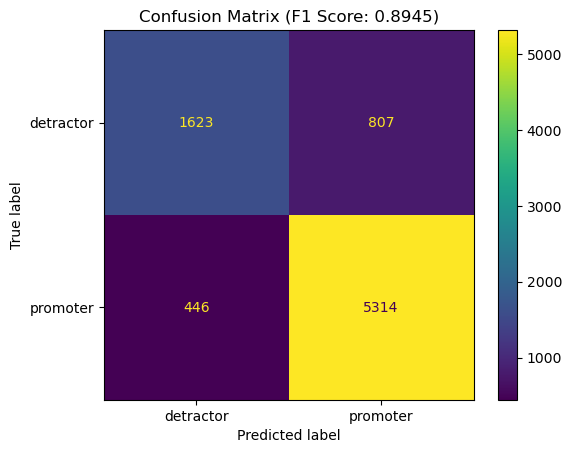

In [166]:
# plotting the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels = ['detractor', 'promoter'])
disp.plot()
plt.title(f'Confusion Matrix (F1 Score: {f1_test:.4f})')
plt.show()

From the confusion matrix, the number of false detractors (446) and false promoters (807) are significantly fewer than the true detractors (1623) and true promoters (5314). 

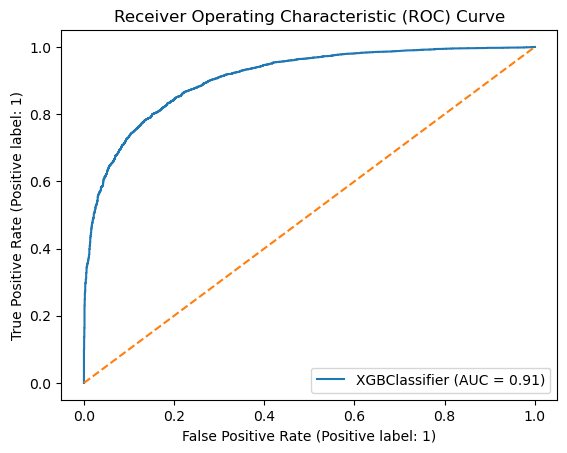

In [162]:
roc_display = RocCurveDisplay.from_estimator(xgb_classifier, X_test_vectorized, y_test)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

With an AUC score of 91%, it means that the model is accrutate at recognizing and identifying reviews as promoters or detractors.

## Saving data for app

In [35]:
data.head()

,restaurant,review_text,word_count,review_rating,restaurant_label
0,Entre Nous creperie,come entre nous periodically past year seem se...,47,5.0,0
1,Entre Nous creperie,absolutely delicious menu lovely offer excepti...,42,5.0,0
2,Entre Nous creperie,thank much choose entre nous creperie recently...,45,5.0,0
3,Entre Nous creperie,lovely little french restaurant really authent...,45,4.5,0
4,Entre Nous creperie,dear rebecca thank much dining entre nous crep...,45,4.0,0


In [36]:
df.head()

,restaurant,review_text,restaurant_label,food_score,service_score,ambiance_score,authentic_score,overall_score,sentiment
0,Entre Nous creperie,come entre nous periodically past year seem se...,0,0.462757,0.427331,0.331545,0.492026,0.428415,1
1,Entre Nous creperie,absolutely delicious menu lovely offer excepti...,0,0.448536,0.318372,0.282956,0.371091,0.355239,1
2,Entre Nous creperie,thank much choose entre nous creperie recently...,0,0.430254,0.381057,0.289790,0.406790,0.376973,1
3,Entre Nous creperie,lovely little french restaurant really authent...,0,0.416918,0.309187,0.258666,0.506409,0.372795,1
4,Entre Nous creperie,dear rebecca thank much dining entre nous crep...,0,0.414757,0.294917,0.352158,0.438276,0.375027,1


In [37]:
# combining the dataframe data with the overall_score and saving it into a csv file

# pd.concat([data, df['overall_score']], axis=1).drop(columns=['restaurant_label']).to_csv('../data/restaurant_review_score.csv')

[Data training for app](../streamlit_deploy/rag_finetuning.ipynb)

## Limitations

**1. Bias in Online Reviews**

Online reviews may be biased and subjective. Reviewers who take the time to leave reviews may not represent the entire customer base, leading to a potential bias in the collected data.

**2. Vague Food Descriptions**

Reviewers often employ subjective terms such as 'nice' and 'average tasting,' resulting in vague descriptions of the food. This inherent ambiguity may pose challenges in extracting precise insights into customer sentiments regarding specific dishes and their authenticity.

**3. Dependency on Periodic NPS Score Checks**

The determination of Net Promoter Scores (NPS) is contingent upon periodic checks as it relies on customer reviews. Regular evaluations are necessary for an updated NPS score, requiring the restaurant to allocate resources for consistent reevaluation over time.

**4. App Limited to Trained Data**

The application's functionality is constrained by the dataset it was initially trained on. In practical terms, this means that the app might not be able to answer questions that is out of the scope of the trained data. This limitation underscores the importance of periodic updates to the training data to ensure the model's adaptability to evolving trends and emerging patterns.

## Recommendations

**For customers/reviewers:**

Enrich Descriptions with Detail

When sharing your culinary experiences, delve into the intricacies of each dish by providing vivid and detailed descriptions. Instead of generic terms, explore rich language to articulate the unique flavors, textures, and aromas. For instance, describe an authentic dish like nasi lemak as having a rich coconut milk-flavored rice, complemented by a sweet yet mildly spicy sambal, and accompanied by crispy, tender chicken.

**For Restaurants/Businesses:**

1. Cultural Events and Collaborations

Incorporating cultural events and collaborations can enrich the dining experience. Consider hosting themed events that celebrate the diverse culinary landscape, fostering community engagement and reinforcing the authenticity of your establishment.

Consider taking part in events such as the Singapore Food Festival that celebrates the diverse culinary landscape or showcase the authenticity of the restaurant's menu through food Expos, reinforcing the authenticity of the establishment.

2. Actively Seeking Customer Feedback on Food Authenticity

Establish accessible channels for patrons to share their experiences, providing valuable insights that contribute to the ongoing improvement of the restaurant's offerings. This dynamic engagement not only ensures customer satisfaction but also demonstrates a dedicated commitment to delivering genuine and authentic dining experiences.

## Conclusion

While the reviews provide only a modest insight into restaurants exclusively focused on authentic cuisine, they unmistakably highlight a discernible demand for traditional dishes. Despite fusion twists, patrons consistently value and seek authentic food experiences. This dual narrative underscores the evolving palate, emphasizing the potential for restaurants to cater to diverse preferences by seamlessly blending innovation with cherished traditional flavors.

## Future work

**1. Cuisine Classification Enhancement**

Enhance the application's analytical depth by incorporating data on the type of cuisines offered by each restaurant, providing a more nuanced understanding of customer preferences and potentially influencing NPS scores.

**2. Experiment with Prompt Engineering**

This entails exploring varied prompt structures, such as explicitly mentioning context or using system messages, to guide the model's behavior. The goal is to enhance contextual understanding, reducing confusion and providing users with a more refined and context-aware conversational experience.

**3. Real-Time NPS Score Monitoring**

Explore the implementation of real-time Net Promoter Score (NPS) monitoring within the application, allowing businesses to proactively track customer satisfaction and make timely adjustments.